In [1]:
import sys
print(sys.version)

3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


In [2]:
# Importing dependencies
import numpy as np
np.random.seed(42)
import tensorflow
tensorflow.random.set_seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
#tensorflow.keras.utils.set_random_seed(42)
plt.style.use('ggplot')

In [3]:
print(pd. __version__)

2.0.2


### Data Preprocessing

In [4]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [5]:
# Loading the dataset
url = '../IR-FX2.csv'
df = pd.read_csv(url,dayfirst=True,parse_dates = True,index_col=0)
df.tail()

,fx,upDown,IR2,Up/Down (2),IR5,Up/Down (5),IR10,Up/Down (10)
date,,,,,,,,
2022-12-22,1.2038,1,-1.1384,0,-0.6878,1,-0.5886,1
2022-12-23,1.2053,0,-1.2141,0,-0.7069,0,-0.6102,0
2022-12-28,1.2018,1,-1.2462,0,-0.8271,0,-0.7227,0
2022-12-29,1.2055,1,-1.2335,1,-0.8100,1,-0.6525,1
2022-12-30,1.2083,0,-1.3498,0,-0.8859,0,-0.7028,0


In [6]:
testing = df.loc['2022/12/22':'2022/12/30']
print(testing.shape)

(5, 8)


In [7]:
# Correlation matrix
df.corr()['IR2']

fx              0.620630
upDown          0.013824
IR2             1.000000
Up/Down (2)     0.011542
IR5             0.969672
Up/Down (5)     0.003268
IR10            0.890314
Up/Down (10)    0.024317
Name: IR2, dtype: float64

In [8]:
print(df.describe().fx) 

count    5645.000000
mean        1.550080
std         0.218064
min         1.068900
25%         1.378300
50%         1.548400
75%         1.659300
max         2.107500
Name: fx, dtype: float64


In [9]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        #print(train[i-timesteps:i])
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print(X_train.shape)
    
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'tanh'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'tanh',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'tanh'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'log_cosh')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [10]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [11]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("GBPUSD Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [12]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [13]:
# Extracting the series
series = df[['fx','IR2','IR5','IR10']] # Picking the features
print(series.shape)
print(series.tail())

(5645, 4)
                fx     IR2     IR5    IR10
date                                      
2022-12-22  1.2038 -1.1384 -0.6878 -0.5886
2022-12-23  1.2053 -1.2141 -0.7069 -0.6102
2022-12-28  1.2018 -1.2462 -0.8271 -0.7227
2022-12-29  1.2055 -1.2335 -0.8100 -0.6525
2022-12-30  1.2083 -1.3498 -0.8859 -0.7028


In [14]:
# Train Val Test Split
train_start = '2000-01-04'
train_end = '2018-05-22'
train_data = series.loc[train_start:train_end]

val_start = '2018-05-23'
val_end = '2020-09-03'
val_data = series.loc[val_start:val_end]

test_start = '2020-09-04'
test_end = '2022-12-30'
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(4516, 4) (564, 4) (565, 4)


In [15]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(4516, 4) (564, 4) (565, 4)


In [16]:
timesteps = 10
hl = [40,35,25]
lr = 1e-4
batch_size = 64
num_epochs = 100

(4506, 10, 4)


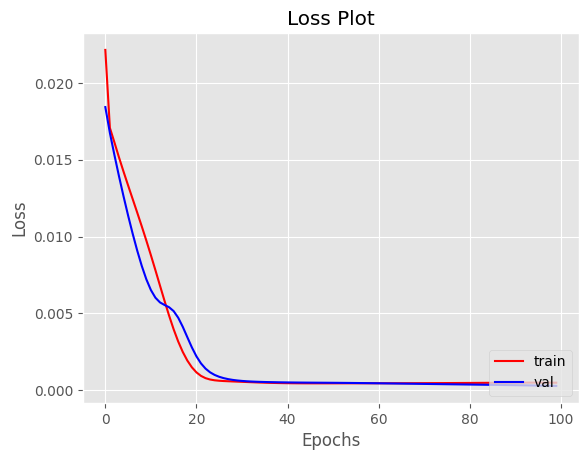

time 225.9858841896057


In [17]:
start = time.time()
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
end = time.time()
plot_error(train_error,val_error)
print('time', end-start)

18/18 [==============================] - 2s 6ms/step
MSE = 0.0005053964229692284
RMSE = 0.022481023619248933
R2-Score = 0.9430281335583408


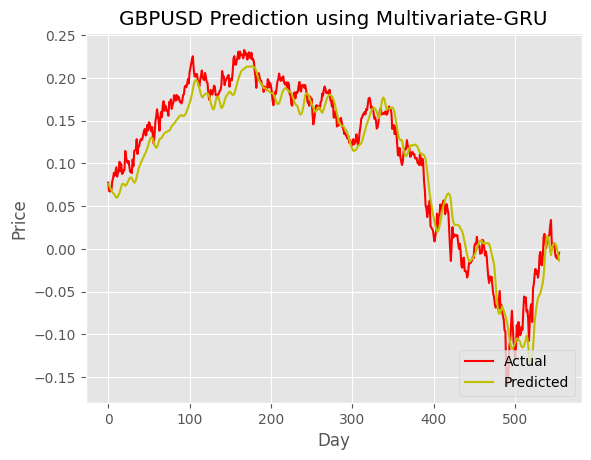

In [18]:
mse,rmse,r2_value,true,predicted = evaluate_model(model,test,10)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)
#print(predicted)
#print(true)

In [19]:
# Save a model
#model.save('IR_Base-GRU_40_[40,35]_1e-4_64.h5')
#del model  #Deletes the model
# Load a model
model = load_model('IR_Base-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [20]:
timesteps = 10
hl = [40,35,25]
lr = 1e-4
batch_size = 64
num_epochs = 100

In [21]:
# Extracting the series
series = df[['fx','IR2','IR5','IR10']] # Picking the features
print(series.shape)
print(series.tail())

(5645, 4)
                fx     IR2     IR5    IR10
date                                      
2022-12-22  1.2038 -1.1384 -0.6878 -0.5886
2022-12-23  1.2053 -1.2141 -0.7069 -0.6102
2022-12-28  1.2018 -1.2462 -0.8271 -0.7227
2022-12-29  1.2055 -1.2335 -0.8100 -0.6525
2022-12-30  1.2083 -1.3498 -0.8859 -0.7028


### Split I, 2001-2005, Pre Crisis

In [22]:
# Train Val Test Split
train_start = '2006-01-03'
train_end = '2022-12-30'
train_data = series.loc[train_start:train_end]

test_start = '2001-01-02'
test_end = '2005-12-30'
test_data = series.loc[test_start:test_end]

In [23]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4173, 4) (1226, 4)


In [24]:
test_data.corr()['fx']

fx      1.000000
IR2     0.071951
IR5     0.171297
IR10    0.344838
Name: fx, dtype: float64

(4163, 10, 4)
38/38 [==============================] - 2s 7ms/step
Split 1
MSE = 0.00037432481419192226
RMSE = 0.01934747565425325
R-Squared Score = 0.985660085957945


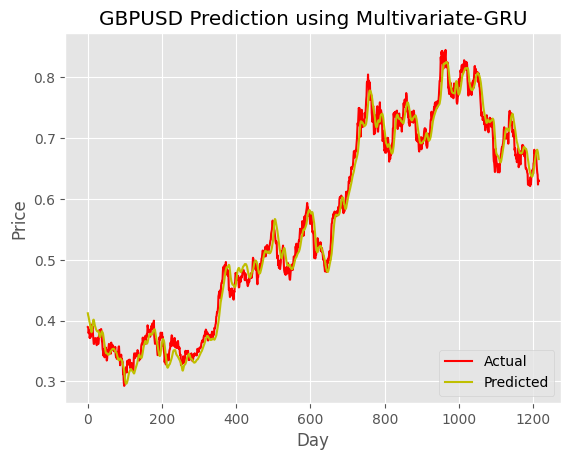

In [25]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse1, rmse1, r2_value1,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse1))
print('RMSE = {}'.format(rmse1))
print('R-Squared Score = {}'.format(r2_value1))
plot_data(true,predicted)
cross_val_results.append([mse1,rmse1,r2_value1,0])
#model.save("MV3-GRU-Split1.h5")

In [26]:
exportdf =pd.DataFrame(true)
exportdf['predicted']=predicted
exportdf.to_excel('crossvaldata.xlsx',sheet_name='new_sheet_name')

In [27]:
df2 = pd.DataFrame().assign(upDown_test=df['upDown'])
df2.tail()

,upDown_test
date,
2022-12-22,1
2022-12-23,0
2022-12-28,1
2022-12-29,1
2022-12-30,0


In [28]:
series_upDown = df2[['upDown_test']]
upDown_testdata = series_upDown.loc[test_start:test_end]
print(upDown_testdata.describe())
print(len(predicted))

       upDown_test
count  1226.000000
mean      0.520392
std       0.499788
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
1216


In [29]:
#Price Movement Accuracy
pred_upDown = []
upDownResults=[]
movement_accuracy=1.123

for i in range(len(predicted)-1):
    if predicted[i][0]<predicted[i+1][0]:
        pred_upDown.append(1)
    else:
        pred_upDown.append(0)
        

for j in range(len(pred_upDown)):
    if pred_upDown[j]!= upDown_testdata.upDown_test[j+9]:
        upDownResults.append(0)
    else:
        upDownResults.append(1)
        
print(upDownResults.count(1))
print(upDownResults.count(0))
movement_accuracy_one=upDownResults.count(1)/(upDownResults.count(1)+upDownResults.count(0))
print('Price movement prediction accuracy:', movement_accuracy_one)


668
547
Price movement prediction accuracy: 0.5497942386831276


In [30]:
#Profit caculation Upside only
longprice=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    
    if pred_upDown[i]==1:
        longprice.append(test_data.fx[i+9])
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
    elif len(longprice)!=0:
        currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
        longprice=[]

currentgbp11 = currentgbp
currentgbp11 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp11)
print('usd', currentusd)

gbp: 733.7397302818513
usd 0


In [31]:
#Profit caculation Bidirectional
longprice=[]
shortprice=[]
trades=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    #print('gbp:', currentgbp)
    #print('usd', currentusd)
    
    if pred_upDown[i] ==1:
        longprice.append(test_data.fx[i+9]) #record long entry price
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
        if len(shortprice) !=0:
            currentusd += (len(shortprice)*test_data.fx[i+9]) #close out all existing short positions
            shortprice=[]
        
    else:
        shortprice.append(test_data.fx[i+9]) #record short entry price
        currentgbp += 1
        currentusd -= test_data.fx[i+9]
        
        if len(longprice) !=0:
            currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
            longprice=[]

currentgbp12 = currentgbp
currentgbp12 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp12)
print('usd', currentusd)

gbp: 1279.3963756678058
usd 0


In [32]:
print(len(upDown_testdata))
print(len(upDownResults))
print(len(pred_upDown))

1226
1215
1215


### Split II, 2006-2010, Crisis

In [125]:
# Train Val Test Split
train_start = '2000-01-04'
train_end = '2005-12-30'
train_start_one = '2011-01-04'
train_end_one =  '2022-12-30'
train_data_one = series.loc[train_start:train_end]
train_data_two = series.loc[train_start_one:train_end_one]
train_data = pd.concat([train_data_one,train_data_two])

test_start = '2006-01-03'
test_end = '2010-12-31'
test_data = series.loc[test_start:test_end]

train_data_one

,fx,IR2,IR5,IR10
date,,,,
2000-01-04,1.6360,1.4520,1.0580,0.3650
2000-01-05,1.6426,1.4120,1.0280,0.3600
2000-01-06,1.6474,1.4640,1.1180,0.4390
2000-01-07,1.6393,1.4020,1.0760,0.3920
2000-01-10,1.6374,1.2990,0.9680,0.2780
...,...,...,...,...
2005-12-22,1.7372,-0.9402,-0.9447,-1.0397
2005-12-23,1.7334,-0.9300,-0.8990,-0.9910
2005-12-28,1.7168,-0.9687,-0.9516,-1.0567


In [126]:
# Normalisation
sc = MinMaxScaler()
train_data_one = sc.fit_transform(train_data_one)
train_data_two = sc.fit_transform(train_data_two)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4173, 4) (1230, 4)


In [128]:
test_data.corr()['fx']

fx      1.000000
IR2     0.571427
IR5     0.458217
IR10    0.317653
Name: fx, dtype: float64

39/39 [==============================] - 3s 8ms/step
Split 2
MSE = 0.005571916899726363
RMSE = 0.07464527379363253
R-Squared Score = 0.943988948908956


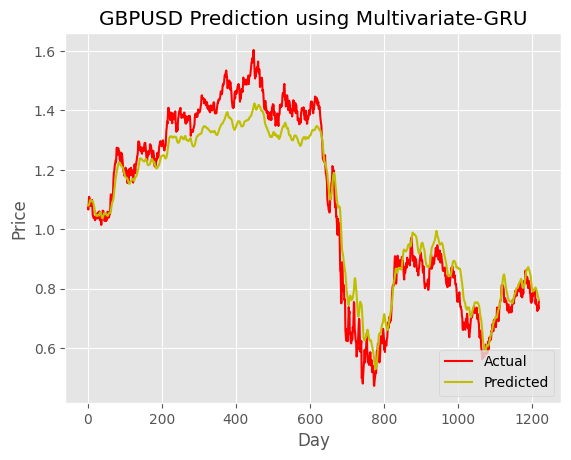

In [40]:
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train_data_one.shape[0]):
    X_train.append(train_data_one[i-timesteps:i])
    Y_train.append(train_data_one[i][0])
    
for i in range(timesteps,train_data_two.shape[0]):
    X_train.append(train_data_two[i-timesteps:i])
    Y_train.append(train_data_two[i][0])
    
    
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse2, rmse2, r2_value2,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse2))
print('RMSE = {}'.format(rmse2))
print('R-Squared Score = {}'.format(r2_value2))
plot_data(true,predicted)
cross_val_results.append([mse2,rmse2,r2_value2,end-start])
#model.save("MV3-GRU-Split2.h5")

In [41]:
exportdf =pd.DataFrame(true)
exportdf['predicted']=predicted
exportdf.to_excel('crossvaldata.xlsx',sheet_name='new_sheet_name')

In [42]:
df2 = pd.DataFrame().assign(upDown_test=df['upDown'])
df2.tail()

,upDown_test
date,
2022-12-22,1
2022-12-23,0
2022-12-28,1
2022-12-29,1
2022-12-30,0


In [43]:
series_upDown = df2[['upDown_test']]
upDown_testdata = series_upDown.loc[test_start:test_end]

In [44]:
#Price Movement Accuracy
pred_upDown = []
upDownResults=[]
movement_accuracy=1.123

for i in range(len(predicted)-1):
    if predicted[i][0]<predicted[i+1][0]:
        pred_upDown.append(1)
    else:
        pred_upDown.append(0)
        

for j in range(len(pred_upDown)):
    if pred_upDown[j]!= upDown_testdata.upDown_test[j+9]:
        upDownResults.append(0)
    else:
        upDownResults.append(1)
        
print(upDownResults.count(1))
print(upDownResults.count(0))
movement_accuracy_two=upDownResults.count(1)/(upDownResults.count(1)+upDownResults.count(0))
print('Price movement prediction accuracy:', movement_accuracy_two)


755
464
Price movement prediction accuracy: 0.6193601312551271


In [45]:
#Profit caculation Upside only
longprice=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    
    if pred_upDown[i]==1:
        longprice.append(test_data.fx[i+9])
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
    elif len(longprice)!=0:
        currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
        longprice=[]

currentgbp21 = currentgbp
currentgbp21 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp21)
print('usd', currentusd)

gbp: 792.4356624764889
usd 0


In [46]:
#Profit caculation Bidirectional
longprice=[]
shortprice=[]
trades=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    #print('gbp:', currentgbp)
    #print('usd', currentusd)
    
    if pred_upDown[i] ==1:
        longprice.append(test_data.fx[i+9]) #record long entry price
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
        if len(shortprice) !=0:
            currentusd += (len(shortprice)*test_data.fx[i+9]) #close out all existing short positions
            shortprice=[]
        
    else:
        shortprice.append(test_data.fx[i+9]) #record short entry price
        currentgbp += 1
        currentusd -= test_data.fx[i+9]
        
        if len(longprice) !=0:
            currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
            longprice=[]

currentgbp22 = currentgbp
currentgbp22 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp22)
print('usd', currentusd)

gbp: 1383.815946873106
usd 0


### Split III, 2011 -2014, Post Crisis

In [129]:
# Train Val Test Split
train_start = '2000-01-04'
train_end = '2010-12-30'
train_start_one = '2015-01-02'
train_end_one =  '2022-12-30'
train_data_one = series.loc[train_start:train_end]
train_data_two = series.loc[train_start_one:train_end_one]
train_data = pd.concat([train_data_one,train_data_two])

test_start = '2011-01-04'
test_end = '2014-12-31'
test_data = series.loc[test_start:test_end]

train_data

,fx,IR2,IR5,IR10
date,,,,
2000-01-04,1.6360,1.4520,1.0580,0.3650
2000-01-05,1.6426,1.4120,1.0280,0.3600
2000-01-06,1.6474,1.4640,1.1180,0.4390
2000-01-07,1.6393,1.4020,1.0760,0.3920
2000-01-10,1.6374,1.2990,0.9680,0.2780
...,...,...,...,...
2022-12-22,1.2038,-1.1384,-0.6878,-0.5886
2022-12-23,1.2053,-1.2141,-0.7069,-0.6102
2022-12-28,1.2018,-1.2462,-0.8271,-0.7227


In [130]:
sc = MinMaxScaler()
train_data_one = sc.fit_transform(train_data_one)
train_data_two = sc.fit_transform(train_data_two)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4173, 4) (980, 4)


In [132]:
test_data.corr()['fx']

fx      1.000000
IR2     0.345825
IR5     0.348334
IR10    0.223799
Name: fx, dtype: float64

31/31 [==============================] - 2s 6ms/step
Split 3
MSE = 0.001495609540587041
RMSE = 0.03867311133833223
R-Squared Score = 0.8228979759187095


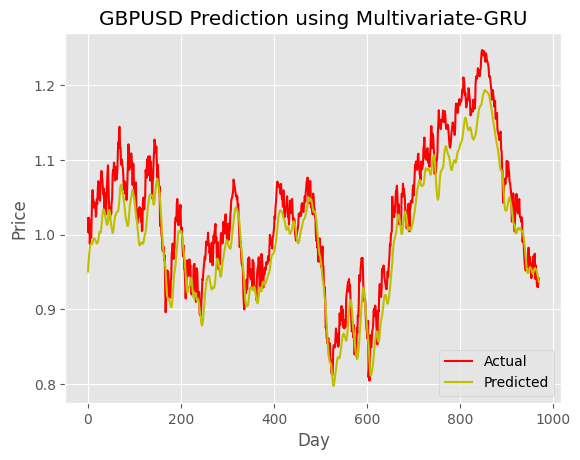

In [97]:
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train_data_one.shape[0]):
    X_train.append(train_data_one[i-timesteps:i])
    Y_train.append(train_data_one[i][0])
    
for i in range(timesteps,train_data_two.shape[0]):
    X_train.append(train_data_two[i-timesteps:i])
    Y_train.append(train_data_two[i][0])
    
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse3, rmse3, r2_value3,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse3))
print('RMSE = {}'.format(rmse3))
print('R-Squared Score = {}'.format(r2_value3))
plot_data(true,predicted)
cross_val_results.append([mse3,rmse3,r2_value3,end-start])
#model.save("MV3-GRU-Split3.h5")

In [51]:
exportdf =pd.DataFrame(true)
exportdf['predicted']=predicted
exportdf.to_excel('crossvaldata.xlsx',sheet_name='new_sheet_name')

In [52]:
df2 = pd.DataFrame().assign(upDown_test=df['upDown'])
df2.tail()

,upDown_test
date,
2022-12-22,1
2022-12-23,0
2022-12-28,1
2022-12-29,1
2022-12-30,0


In [53]:
series_upDown = df2[['upDown_test']]
upDown_testdata = series_upDown.loc[test_start:test_end]

In [54]:
#Price Movement Accuracy
pred_upDown = []
upDownResults=[]
movement_accuracy=1.123

for i in range(len(predicted)-1):
    if predicted[i][0]<predicted[i+1][0]:
        pred_upDown.append(1)
    else:
        pred_upDown.append(0)
        

for j in range(len(pred_upDown)):
    if pred_upDown[j]!= upDown_testdata.upDown_test[j+9]:
        upDownResults.append(0)
    else:
        upDownResults.append(1)
        
print(upDownResults.count(1))
print(upDownResults.count(0))
movement_accuracy_three=upDownResults.count(1)/(upDownResults.count(1)+upDownResults.count(0))
print('Price movement prediction accuracy:', movement_accuracy_three)


792
177
Price movement prediction accuracy: 0.8173374613003096


In [55]:
#Profit caculation Upside only
longprice=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    
    if pred_upDown[i]==1:
        longprice.append(test_data.fx[i+9])
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
    elif len(longprice)!=0:
        currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
        longprice=[]

currentgbp31 = currentgbp
currentgbp31 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp31)
print('usd', currentusd)

gbp: 596.0790307803228
usd 0


In [56]:
#Profit caculation Bidirectional
longprice=[]
shortprice=[]
trades=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    #print('gbp:', currentgbp)
    #print('usd', currentusd)
    
    if pred_upDown[i] ==1:
        longprice.append(test_data.fx[i+9]) #record long entry price
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
        if len(shortprice) !=0:
            currentusd += (len(shortprice)*test_data.fx[i+9]) #close out all existing short positions
            shortprice=[]
        
    else:
        shortprice.append(test_data.fx[i+9]) #record short entry price
        currentgbp += 1
        currentusd -= test_data.fx[i+9]
        
        if len(longprice) !=0:
            currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
            longprice=[]

currentgbp32 = currentgbp
currentgbp32 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp32)
print('usd', currentusd)

gbp: 1073.3936613253575
usd 0


### Split IV, 2015-2018, Post Crisis/Pre Covid

In [54]:
# Train Val Test Split
train_start = '2000-01-04'
train_end = '2014-12-31'
train_start_one = '2019-01-02'
train_end_one =  '2022-12-30'
train_data_one = series.loc[train_start:train_end]
train_data_two = series.loc[train_start_one:train_end_one]
train_data = pd.concat([train_data_one,train_data_two])

test_start = '2015-01-02'
test_end = '2018-12-31'
test_data = series.loc[test_start:test_end]

train_data

,fx,IR2,IR5,IR10
date,,,,
2000-01-04,1.6360,1.4520,1.0580,0.3650
2000-01-05,1.6426,1.4120,1.0280,0.3600
2000-01-06,1.6474,1.4640,1.1180,0.4390
2000-01-07,1.6393,1.4020,1.0760,0.3920
2000-01-10,1.6374,1.2990,0.9680,0.2780
...,...,...,...,...
2022-12-22,1.2038,-1.1384,-0.6878,-0.5886
2022-12-23,1.2053,-1.2141,-0.7069,-0.6102
2022-12-28,1.2018,-1.2462,-0.8271,-0.7227


In [55]:
sc = MinMaxScaler()
train_data_one = sc.fit_transform(train_data_one)
train_data_two = sc.fit_transform(train_data_two)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4173, 4) (984, 4)


In [56]:
test_data.corr()['fx']

fx      1.000000
IR2     0.659703
IR5     0.723728
IR10    0.678676
Name: fx, dtype: float64

31/31 [==============================] - 0s 6ms/step
Split 4
MSE = 0.0011909418300486117
RMSE = 0.0345100250658937
R-Squared Score = 0.986662840258778


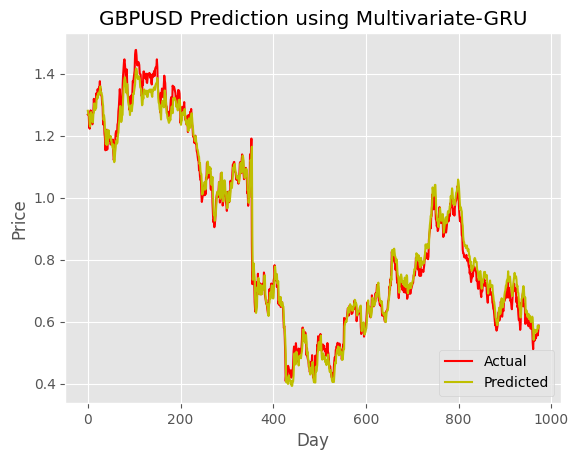

In [64]:
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train_data_one.shape[0]):
    X_train.append(train_data_one[i-timesteps:i])
    Y_train.append(train_data_one[i][0])
    
for i in range(timesteps,train_data_two.shape[0]):
    X_train.append(train_data_two[i-timesteps:i])
    Y_train.append(train_data_two[i][0])
    
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse4, rmse4, r2_value4,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse4))
print('RMSE = {}'.format(rmse4))
print('R-Squared Score = {}'.format(r2_value4))
plot_data(true,predicted)
cross_val_results.append([mse4,rmse4,r2_value4,end-start])
#model.save("MV3-GRU-Split4.h5")

In [65]:
exportdf =pd.DataFrame(true)
exportdf['predicted']=predicted
exportdf.to_excel('crossvaldata.xlsx',sheet_name='new_sheet_name')

In [66]:
df2 = pd.DataFrame().assign(upDown_test=df['upDown'])
df2.tail()

,upDown_test
date,
2022-12-22,1
2022-12-23,0
2022-12-28,1
2022-12-29,1
2022-12-30,0


In [67]:
series_upDown = df2[['upDown_test']]
upDown_testdata = series_upDown.loc[test_start:test_end]

In [68]:
#Price Movement Accuracy
pred_upDown = []
upDownResults=[]
movement_accuracy=1.123

for i in range(len(predicted)-1):
    if predicted[i][0]<predicted[i+1][0]:
        pred_upDown.append(1)
    else:
        pred_upDown.append(0)
        

for j in range(len(pred_upDown)):
    if pred_upDown[j]!= upDown_testdata.upDown_test[j+9]:
        upDownResults.append(0)
    else:
        upDownResults.append(1)
        
print(upDownResults.count(1))
print(upDownResults.count(0))
movement_accuracy_four=upDownResults.count(1)/(upDownResults.count(1)+upDownResults.count(0))
print('Price movement prediction accuracy:', movement_accuracy_four)


900
73
Price movement prediction accuracy: 0.9249743062692704


gbp: 14.857608019368207
usd 0


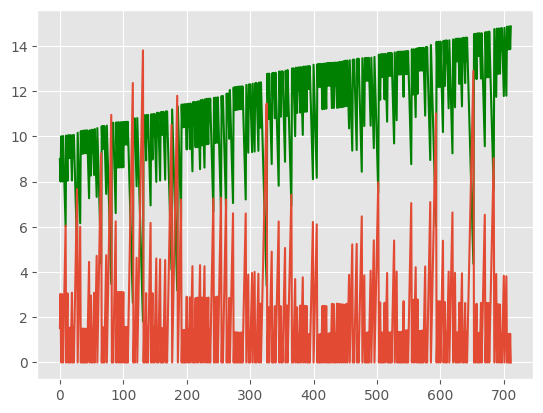

In [96]:
#Profit caculation Upside only
currentgbp = 10
currentusd = 0
currentgbplist=[]
currentusdlist=[]

for i in range(len(pred_upDown)):
    
    if pred_upDown[i]==0:
        currentgbp -= 1
        currentgbplist.append(currentgbp)
        currentusd += test_data.fx[i+9]
        currentusdlist.append(currentusd)
        
    elif currentusd>0:
        currentgbp += (currentusd/test_data.fx[i+9]) #close out all existing long positions
        currentusd=0
        currentgbplist.append(currentgbp)
        currentusdlist.append(currentusd)
    
currentgbp41 = currentgbp
currentgbp41 += currentusd/test_data.fx[-1]
currentusd = 0
plt.plot(currentgbplist, 'g')
plt.plot(currentusdlist)

print('gbp:', currentgbp41)
print('usd', currentusd)

gbp: 110.18765684420474
usd 0


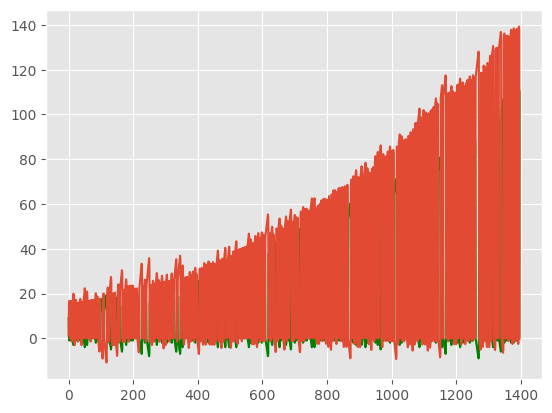

In [97]:
#Profit caculation Bidirectional
currentgbplist=[]
currentusdlist=[]
trades=[]
currentgbp = 10
currentusd = 0

for i in range(len(pred_upDown)):
   
    if pred_upDown[i] ==0:
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        currentusdlist.append(currentusd) #record long entry price
        currentgbplist.append(currentgbp)
        
        if currentgbp >0:
            currentusd += (currentgbp*test_data.fx[i+9]) #close out all existing short positions
            currentgbp=0
            currentusdlist.append(currentusd) 
            currentgbplist.append(currentgbp)
        
    else:
        currentgbp += 1
        currentusd -= test_data.fx[i+9]
        currentusdlist.append(currentusd) 
        currentgbplist.append(currentgbp)
        
        if currentusd >0:
            currentgbp += (currentusd/test_data.fx[i+9]) #close out all existing long positions
            currentusd=0
            currentusdlist.append(currentusd) 
            currentgbplist.append(currentgbp)
           
plt.plot(currentgbplist,'g')     
plt.plot(currentusdlist)  
currentgbp42 = currentgbp
currentgbp42 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp42)
print('usd', currentusd)

### Split V, 2019-2022, Moderate Crisis (Covid)

In [136]:
# Train Val Test Split
train_start = '2000-01-04'
train_end = '2018-12-31'
train_data = series.loc[train_start:train_end]

test_start = '2019-01-02'
test_end = '2022-12-30'
test_data = series.loc[test_start:test_end]

In [137]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4666, 4) (979, 4)


In [140]:
test_data.corr()['fx']

fx      1.000000
IR2     0.467880
IR5     0.267495
IR10    0.058856
Name: fx, dtype: float64

(4656, 10, 4)
Epoch 96: early stopping
31/31 [==============================] - 2s 6ms/step
Split 1
MSE = 0.00034695491409866255
RMSE = 0.018626725801886453
R-Squared Score = 0.9433195021975985


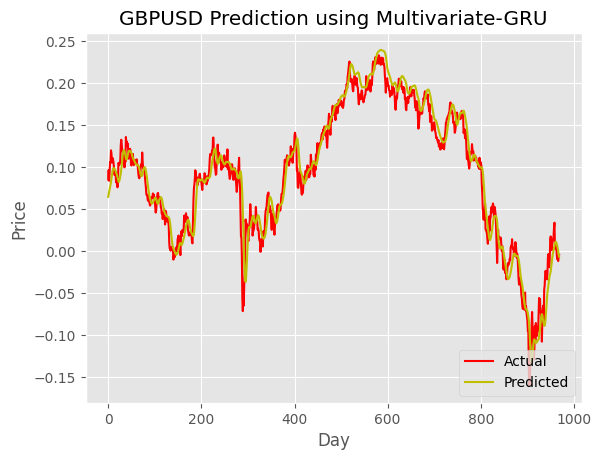

In [101]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse5, rmse5, r2_value5,true,predicted = evaluate_model(model,test,timesteps)

print("Split 1")
print('MSE = {}'.format(mse5))
print('RMSE = {}'.format(rmse5))
print('R-Squared Score = {}'.format(r2_value5))
plot_data(true,predicted)
cross_val_results.append([mse5,rmse5,r2_value5,0])
#model.save("MV3-GRU-Split1.h5")

In [71]:
exportdf =pd.DataFrame(true)
exportdf['predicted']=predicted
exportdf.to_excel('crossvaldata.xlsx',sheet_name='new_sheet_name')

In [102]:
series_upDown = df2[['upDown_test']]
upDown_testdata = series_upDown.loc[test_start:test_end]
print(upDown_testdata)

            upDown_test
date                   
2019-01-02            1
2019-01-03            1
2019-01-04            1
2019-01-07            0
2019-01-08            1
...                 ...
2022-12-22            1
2022-12-23            0
2022-12-28            1
2022-12-29            1
2022-12-30            0

[979 rows x 1 columns]


In [103]:
#Price Movement Accuracy
pred_upDown = []
upDownResults=[]
movement_accuracy=1.123

for i in range(len(predicted)-1):
    if predicted[i][0]<predicted[i+1][0]:
        pred_upDown.append(1)
    else:
        pred_upDown.append(0)
        

for j in range(len(pred_upDown)):
    if pred_upDown[j]!= upDown_testdata.upDown_test[j+9]:
        upDownResults.append(0)
    else:
        upDownResults.append(1)
        
print(upDownResults.count(1))
print(upDownResults.count(0))
movement_accuracy_five=upDownResults.count(1)/(upDownResults.count(1)+upDownResults.count(0))
print('Price movement prediction accuracy:', movement_accuracy_five)


516
452
Price movement prediction accuracy: 0.5330578512396694


gbp: 97.57003345874153
usd 0


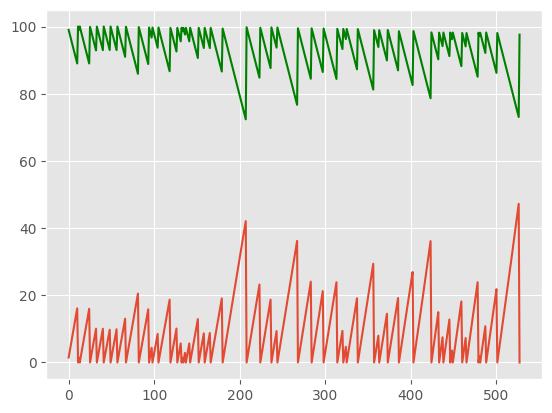

In [155]:
#Profit caculation Upside only
longprice=[]
currentgbp = 100
currentusd = 0
currentgbplist=[]
currentusdlist=[]

for i in range(len(pred_upDown)):
    
    if pred_upDown[i]==1:
        longprice.append(test_data.fx[i+9])
        currentgbp -= 1
        currentgbplist.append(currentgbp)
        currentusd += test_data.fx[i+9]
        currentusdlist.append(currentusd)
        
    elif len(longprice)!=0:
        currentgbp += (currentusd/test_data.fx[i+9]) #close out all existing long positions
        currentusd=0

        currentgbplist.append(currentgbp)
        currentusdlist.append(currentusd)
        longprice=[]
    
    
currentgbp51 = currentgbp
currentgbp51 += currentusd/test_data.fx[-1]
currentusd = 0
plt.plot(currentgbplist, 'g')
plt.plot(currentusdlist)
print('gbp:', currentgbp51)
print('usd', currentusd)

In [153]:
#Profit caculation Bidirectional
longprice=[]
shortprice=[]
trades=[]
currentgbp = 100
currentusd = 0

for i in range(len(pred_upDown)):
    #print('gbp:', currentgbp)
    #print('usd', currentusd)
    
    if pred_upDown[i] ==1:
        longprice.append(test_data.fx[i+9]) #record long entry price
        currentgbp -= 1
        currentusd += test_data.fx[i+9]
        
        if len(shortprice) !=0:
            currentusd += (len(shortprice)*test_data.fx[i+9]) #close out all existing short positions
            shortprice=[]
        
    else:
        shortprice.append(test_data.fx[i+9]) #record short entry price
        currentgbp += 1
        currentusd -= test_data.fx[i+9]
        
        if len(longprice) !=0:
            currentgbp += (sum(longprice)*(1/test_data.fx[i+9])) #close out all existing long positions
            longprice=[]

currentgbp52 = currentgbp
currentgbp52 += currentusd/test_data.fx[-1]
currentusd = 0
print('gbp:', currentgbp52)
print('usd', currentusd)

gbp: 1024.329754874876
usd 0


In [76]:
print('2001-2005')
print('Price movement accuracy: ', movement_accuracy_one)
print('Profit pre-crisis upside: ', currentgbp11)
print('Profit pre-crisis both directions: ', currentgbp12)
print('\n')

print('2016-2010')
print('Price movement accuracy: ', movement_accuracy_two)
print('Profit crisis upside: ', currentgbp21)
print('Profit crisis both directions: ', currentgbp22)
print('\n')

print('2011-2014')
print('Price movement accuracy: ', movement_accuracy_three)
print('Profit post-crisis upside: ', currentgbp31)
print('Profit post-crisis both directions: ', currentgbp32)
print('\n')

print('2015-2018')
print('Price movement accuracy: ', movement_accuracy_four)
print('Profit pre-covid upside: ', currentgbp41)
print('Profit pre-covid both directions: ', currentgbp42)
print('\n')

print('2019-2022')
print('Price movement accuracy: ', movement_accuracy_five)
print('Profit moderate-crisis (covid) upside: ', currentgbp51)
print('Profit moderate-crisis both directions: ', currentgbp52)

2001-2005
Price movement accuracy:  0.5522633744855967
Profit pre-crisis upside:  722.3382583714554
Profit pre-crisis both directions:  1281.4760993464984


2016-2010
Price movement accuracy:  0.6193601312551271
Profit crisis upside:  792.4356624764889
Profit crisis both directions:  1383.815946873106


2011-2014
Price movement accuracy:  0.8173374613003096
Profit post-crisis upside:  596.0790307803228
Profit post-crisis both directions:  1073.3936613253575


2015-2018
Price movement accuracy:  0.9331963001027749
Profit pre-covid upside:  609.818146540789
Profit pre-covid both directions:  1099.0521123554354


2019-2022
Price movement accuracy:  0.5382231404958677
Profit moderate-crisis (covid) upside:  628.9088604772297
Profit moderate-crisis both directions:  1097.2552148594189


In [77]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.0003567147578715768
Avg. RMSE = 0.018886893812153888
Avg. R2-score = 0.9417250794612625


In [78]:
CV_results.to_csv('MV3-GRU_CrossValidation.csv')
train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')